## 6.1 anomaly detection basic1

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.10.25 </div>
<div style="text-align: right\"> Last update: 2021.10.25</div>

- 출처 : https://medium.com/analytics-vidhya/anomaly-detection-in-python-part-1-basics-code-and-standard-algorithms-37d022cdbcff

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

AD 종류  
- 지도 : 분류문제로 진행  
- 준지도 : 학습할 때 정상 데이터만 사용, 예측할 때는 비정상 데이터 ... autoencoder  
- 비지도 : 데이터에 정상, 비정상 포함, 그러나 레이블 없음

여기서는 비지도 기반 방법을 소개

비지도 학습 기반 방법은 3종류가 있음  
1. Business/Domain based EDA  
2. Univariate Methods(Tukey’s Method, z-Score, etc)  
3. Multivariate Methods(Mahalanobis Distance(using MCD), One-Class SVM, Isolation Forests, etc)  

### Business / Domain based EDA

가장 우선적으로 실행될 수 있는 방법

1. 박스 플롯과 히스토그램을 그려서 극단적인 값을 찾는 방법   
2. 스캐터 플롯 : 의존성이 큰 두 변수로 그려서 이탈 지점 찾음

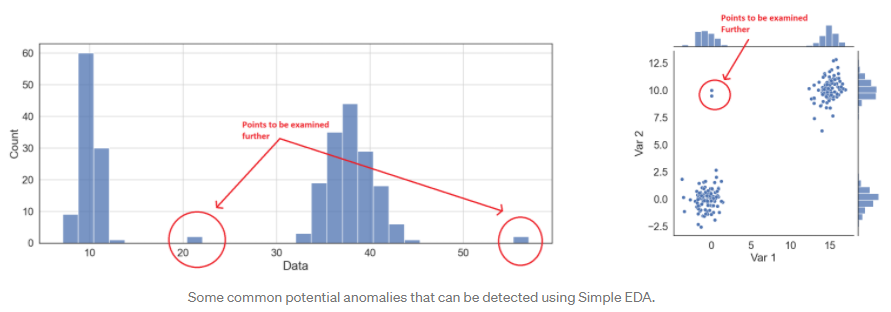

The Scatterplot shows an interesting scenario — The 2 isolated highlighted points do not look like anomalies if only the marginal histograms are looked at. Only when we plot the 2 variables in a scatterplot, we see that the COMBINATION of values taken by Var1, Var2 is unusual — not the individual values of Var1 or Var2. This is an example of a case where plotting univariate histograms would not work in identifying the anomalies. This kind of an anomaly is a Multivariate Anomaly and is discussed later on in the article.

### Univariate methods

We will briefly discuss Tukey’s Method which treats extreme values in data as outliers/anomalies:

In Tukey’s method, we define a lower limit and upper limit. Data within these limits, is considered ‘clean’. The lower and upper limits are determined in a robust way. That means, that the upper and lower limits do not get influenced by the presence of the outliers. This is a distinction from some other methods like the z-score method, where the lower and upper limits are influenced by the outliers. In general, it is better to use robust methods.  
The Upper and Lower limits are defined as follows:  
**Lower Limit = 25th Percentile — k*IQR**  
**Upper Limit = 75th Percentile + k*IQR**  
Where, k is generally 1.5 but must be adjusted if required. IQR is the Inter-Quartile Range(IQR = 75th Percentile — 25th Percentile of data) of the variable. Values in data below the lower limit or above the upper limit are called outliers.

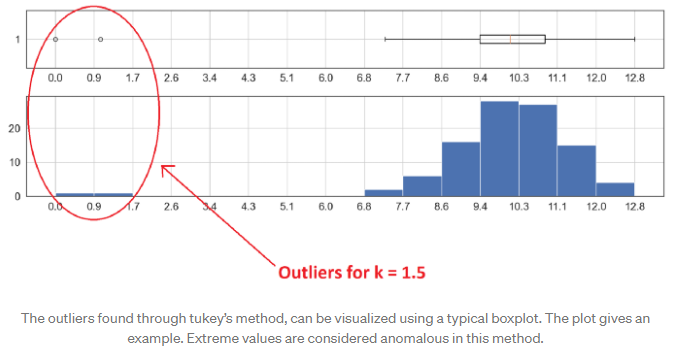

The following function replaces the outliers identified by tukey’s method(values beyond the limits defined above) by NaN:

In [4]:
def tukey(x, k = 1.5):
    x = np.array(x).copy().astype(float)
    first_quartile = np.quantile(x, .25)
    third_quartile = np.quantile(x, .75)
    
    # Define IQR
    iqr = third_quartile - first_quartile
    
    ### Define the allowed limits for 'Normal Data'
    lower_allowed_limit = first_quartile - (k * iqr)
    upper_allowed_limit = third_quartile + (k * iqr)
    
    #set values below the lower limit/above the upper limit as nan
    x[(x<lower_allowed_limit) | (x>upper_allowed_limit)] = np.nan
    return x

Some other Univariate Methods are z-score method and Median Absolute Deviation method-each with its own pros and cons.

### Multivariate methods

자동차의 주행기록계(odo)와 rpm을 예로들어보자.

Let us say that the odo takes values in the range of 0–50mph and rpm takes values in the range of 0–650 rpm. We expect the readings of the 2 features to be correlated i.e. a large rpm will cause the odometer to record higher speeds.

Now, imagine we record a value of 0 on the rpm sensor. We conclude that the car is not moving. Similarly, say while driving, if the odo reads 25mph, we conclude that the car is moving. However, none of these values is an outlier — because they represent perfectly normal modes of operation.

owever, let us imagine we note that the odo reads 25 but at the same time, the rpm reads 0. This looks unreasonable. The odo value of 25 in itself is not unreasonable; and rpm of 0 is also not unreasonable(as discussed above)but for them to take those values at the same time is unreasonable. This is an example of a multivariate outlier. Multivariate outliers are observations for which the combination of values taken by the features is improbable. The important thing here is to consider the values of all the features at the same time — as opposed to taking one feature at a time which we did when we discussed univariate methods. Multivariate outliers need specialized methods — and cannot be, in general detected by univariate methods unless the features take extreme values individually. They are also very difficult to detect — the above example had 2 variables(odo and rpm) and that is why we could spot the outlier easily — however, the problem becomes impossible to do manually when we have hundreds of variables. Using Multivariate methods can make the process easy for us even when dealing with hundreds of variables.

Multivariate outlier는 두 값의 조합이 일어날 가능성이 적은 형태가 측정되는 것이다.

Multivariate outliers need specialized methods — and cannot be, in general detected by univariate methods unless the features take extreme values individually. They are also very difficult to detect — the above example had 2 variables(odo and rpm) and that is why we could spot the outlier easily — however, the problem becomes impossible to do manually when we have hundreds of variables. Using Multivariate methods can make the process easy for us even when dealing with hundreds of variables.

앞에서는 두 변수를 예로 들었지만, 실제에는 아주 많은 변수가 엮여있는 경우가 많다.

**Mahalanobis Distance Method using FastMCD Algorithm:**

The Mahalanobis distance는 특정 포인트의 분포와의 거리를 측정한 것으로 생각될 수 있다.   
When using it to detect anomalies, we consider the ‘Clean’ data to be the distribution. If the Mahalanobis distance of a point from the ‘Clean’ Data is high, we consider it to be an anomaly. This method assumes the clean data to be Multivariate Normal but in practice, it can be used even for a variety of other cases.

1. If the data follows a multivariate normal distribution, all points having the same probability have the same mahalanobis distance from the mean value of the distribution.  
2. Higher the Mahalanobis distance of a point from the mean of the normal distribution, lower is the probability of that point. Now, it makes sense from a statistical perspective — as to why points having large Mahalanobis distance are potential anomalies — because they correspond to low probabilities.  

A normal distribution is uniquely determined by its mean and covariance matrix which needs to be estimated from data. However, we use the FastMCD Algorithm to determine the mean and covariance matrix of the normal distribution. We use the FastMCD Algorithm because we want a robust estimate of the mean and covariance. If we were to use the direct formulae of mean and covariance, then the outliers would also contribute to calculating the mean and covariance-which is not what we want. Following is a good resource to learn about FastMCD:

Fortunately, Scikit-learn has a very convenient way of using this method. Following are the steps:  
1. Fit sklearn.covariance.EllipticEnvelope() to data: This calculates the robust mean and covariance of the data using the FastMCD Algorithm. We need to pass it the value of contamination which is an estimate of what fraction of data we expect to be anomalous.  
2. Predict: Predict the outlier/anomaly status of each data point. Points labelled -1 by the algorithm are anomalies and +1 are not anomalies.  
Here is the example from before:

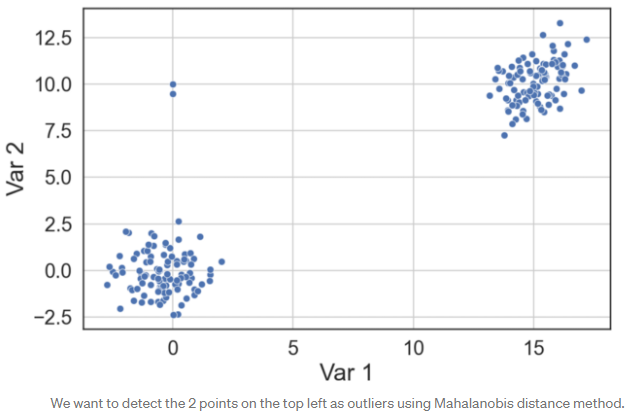

In [5]:
### Create the Data
d1 = np.random.multivariate_normal(mean = np.array([-.5, 0]),
                               cov = np.array([[1, 0], [0, 1]]), size = 100)
d2 = np.random.multivariate_normal(mean = np.array([15, 10]),
                               cov = np.array([[1, 0.3], [.3, 1]]), size = 100)
outliers = np.array([[0, 10],[0, 9.5]])
d = pd.DataFrame(np.concatenate([d1, d2, outliers], axis = 0), columns = ['Var 1', 'Var 2'])

In [6]:
d

,Var 1,Var 2
0,-1.782625,0.299816
1,-1.268080,0.920105
2,-0.113593,0.855020
3,-1.468536,0.993321
4,0.707414,1.062220
...,...,...
197,15.238761,12.152650
198,13.280150,8.246026
199,14.687267,9.703917
200,0.000000,10.000000


In [8]:
from sklearn import covariance

In [9]:
# Define the Elliptic Envelope
el = covariance.EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, 
                                    contamination=0.0075, random_state=0)

In [10]:
el

EllipticEnvelope(contamination=0.0075, random_state=0)

In [11]:
# Fit the data - this is where FastMCD is used by sklearn
el.fit(d)

EllipticEnvelope(contamination=0.0075, random_state=0)

In [12]:
# Create column that shows anomaly status
d['Anomaly or Not'] = el.predict(d)

In [13]:
d

,Var 1,Var 2,Anomaly or Not
0,-1.782625,0.299816,1
1,-1.268080,0.920105,1
2,-0.113593,0.855020,1
3,-1.468536,0.993321,1
4,0.707414,1.062220,1
...,...,...,...
197,15.238761,12.152650,1
198,13.280150,8.246026,1
199,14.687267,9.703917,1
200,0.000000,10.000000,-1


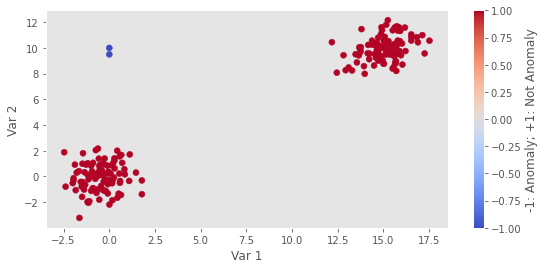

In [14]:
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (9, 4))
ax = plt.scatter(d['Var 1'], d['Var 2'], c = d['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()

As we can see, the method works — it detects multivariate anomalies. It can be used for data having hundreds of dimensions. Setting the contamination is very important. To see that, let us check the results of the algorithm as we set different values for the contamination.

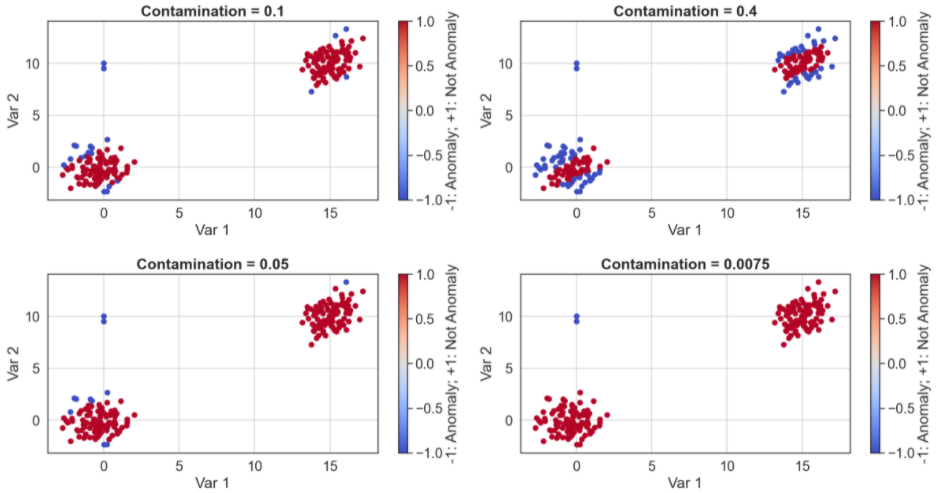

위에서 볼 수 있듯이 contamination level을 정하는 것이 중요하다.

contamination level은 전체에서 비정상 샘플의 비율을 뜻한다.

contamination  level 값을 모른다면??  

1. Fit the sklearn.covariance.EllipticEnvelope() to data.  
2. Calculate the Mahalanobis distance of each data point from the robust mean by using the mahalanobis() method.  
3. Visualize the distribution of Mahalanobis distances present in data. Identify a threshold above which a point will be called an outlier — by visualizing the distribution of the Distances OR Use a univariate Anomaly detection algorithm on the distances to find out which distances are anomalous.

사실 contamination level은 문제가 되지 않는다. 아래처럼 임의의 값을 넣고 시작해보자.

In [15]:
# Create Data - with Anomaly - as before.
d1 = np.random.multivariate_normal(mean = np.array([-.5, 0]),
                               cov = np.array([[1, 0], [0, 1]]), size = 100)
d2 = np.random.multivariate_normal(mean = np.array([15, 10]),
                               cov = np.array([[1, 0.3], [.3, 1]]), size = 100)
outliers = np.array([[0, 10],[0, 9.5]])
d = pd.DataFrame(np.concatenate([d1, d2, outliers], axis = 0), columns = ['Var 1', 'Var 2'])

In [16]:
###### Fit Elliptic Envelope ##############
contamination = .4 # We can set any value here as we will now use our own threshold
el = covariance.EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, 
                                    contamination=contamination, random_state=0)
# Fit the data
el.fit(d)

EllipticEnvelope(contamination=0.4, random_state=0)

In [17]:
############# New Part ################
# Create column that measures Mahalanobis distance
d['Mahalanobis Distance'] = el.mahalanobis(d)

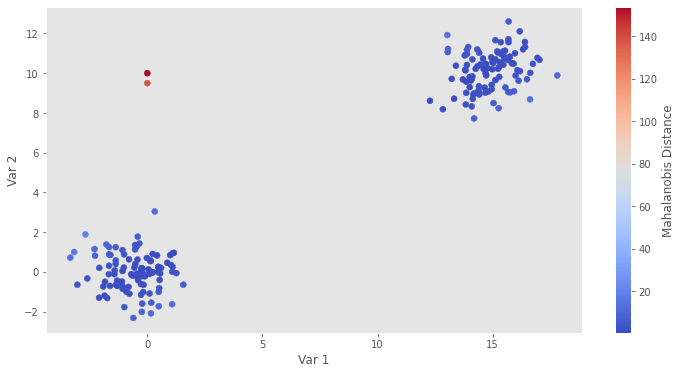

In [18]:
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (12, 6))
ax = plt.scatter(d['Var 1'], d['Var 2'], c = d['Mahalanobis Distance'], cmap = 'coolwarm')
#plt.title('Contamination = Does not matter for this method', weight = 'bold')
#ax = sns.scatterplot(d['Var 1'], d['Var 2'], c = d['Anomaly or Not'])
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = 'Mahalanobis Distance')
plt.grid()

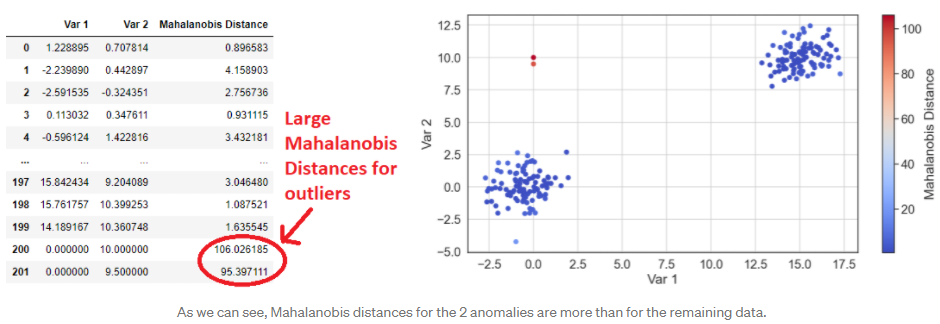

한가지 방법중 하나는 Mahalanobis distance를 구하는 방법이다.  
이 방법은 2D 데이터를 1D로 바꾸는 방법이다.  
따라서 이제 univariate anomaly detectio 문제가 되었다.

이를 사용해서 박스플롯을 그리던지 터키 방법을 사용하여 이상탐지를 하면 된다.

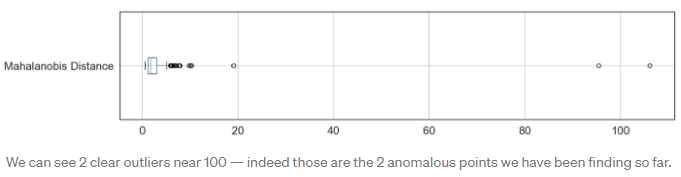

We clearly see the 2 points near 100 as strong anomalies now. There is one more point near 20 that is being labelled as an anomaly — which needs to be analyzed further.
What we just did, is a standard technique — We converted a Multivariate Outlier detection problem into a univariate outlier detection problem by calculating the Mahalanobis distance of each point from the robust mean. Then, we applied a Univariate method on this distance.
Alternately, we can simply make a histogram and visually identify a good threshold.
NOTE: The Mahalanobis distance method works even for hundreds of features. For ease of Visualization, I have used 2 variables for the discussion.